In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

Successfully pivoted the filtered dataset


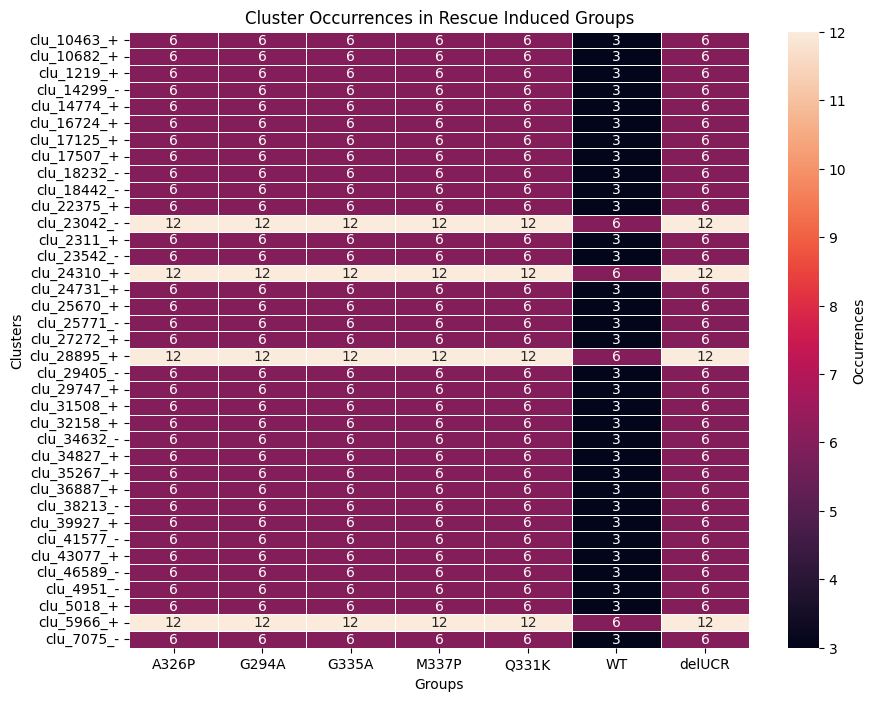

In [2]:
'''
HEATMAP ANALYSIS

This is an attempt to visualise which genotypes have higher or lower rescued groups, and which clusters are rescued.
'''

# read in filtered data
input_data = pd.read_csv('filtered_data.csv')

# pivot table to count occurrences of each cluster (event) in each group
try:    
    pivot_table = input_data.pivot_table(index='cluster', columns='genotype', aggfunc='size', fill_value=0)
    print('Successfully pivoted the filtered dataset')
except Exception as e:
    print(f"Error making heatmap: {e}")
    raise

# make heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, linewidth=.5, cbar_kws={'label': 'Occurrences'})
plt.title("Cluster Occurrences in Rescue Induced Groups")
plt.xlabel("Groups")
plt.ylabel("Clusters")

plt.show()

It seems some clusters have double the rescue expression rate (clu_5966_+, clu_28895_+, clu_23042_-) than all other clusters

Regarding the groups, the rescue expression rate is the same between groups, with the only anomaly being the WT group.

WT has a relatively high condensation propensity and full CR helix. 

In [3]:
'''
PCA on psi values (SECOND ATTEMPT)

USEFUL PARAMETERS FOR PCA:
psi - splicing efficiency
junction_coords - this variable should show which events are driving differences in samples
sample_names - 

Dataset:
unfiltered_cryptic_data = filtered junctions to all TDP_kd, all cryptics, but not all rescued.

Outputs:

'''

input_data = pd.read_csv('unfiltered_cryptic_data.csv')
input_data = input_data.dropna()

# Pre-process data
#input_data['rescue_encoded'] = input_data['rescueExpression'].map({'rescueInduced': 1, 'rescueNotInduced': 0})


# One hot encode sample names
encoded_genotypes = pd.get_dummies(input_data['sample_name'])
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(input_data[['sample_name']])
encoded_samples_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())
one_hot_encoded = encoder.fit_transform(input_data[['junction_coords']])
encoded_junctions_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())


# Gather the useful data for PCA
processed_data = pd.concat([
    input_data[['psi']],
    encoded_samples_df, encoded_junctions_df
], axis=1)


processed_data = processed_data.dropna()

# Run PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(processed_data)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# Save PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])
pca_df['rescueExpression'] = input_data['rescueExpression']

print('PCA completed successfully')

PCA completed successfully


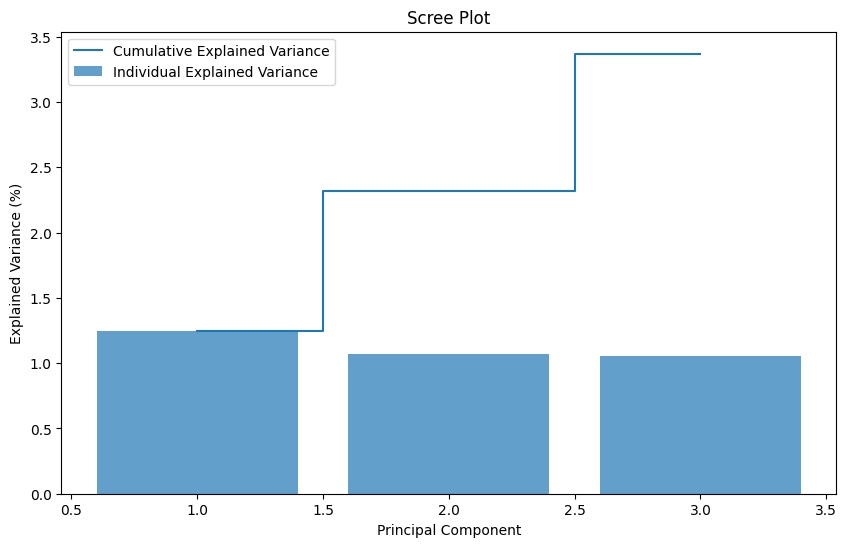

Loading Scores for Principal Components:
                                               PC1       PC2       PC3
psi                                       0.693062  0.013834  0.042668
sample_name_201812_A326P_pos_siT_1       -0.036298  0.037204  0.019684
sample_name_201812_A326P_pos_siT_2       -0.046723  0.060187  0.066384
sample_name_201812_A326P_pos_siT_3       -0.044952  0.050988  0.034926
sample_name_201812_G294A_pos_siT_1        0.027319  0.041571  0.037744
...                                            ...       ...       ...
junction_coords_chr5:78489153-78564813   -0.075135 -0.025205 -0.049743
junction_coords_chr6:158017290-158019984  0.087164 -0.013087  0.002565
junction_coords_chr7:100050836-100056911  0.003271 -0.019351 -0.024473
junction_coords_chr7:45735670-45736787   -0.030994 -0.021909 -0.035516
junction_coords_chr9:76638288-76641790   -0.000192 -0.019609 -0.025589

[102 rows x 3 columns]


In [5]:
"""
POST PCA analysis
"""

loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=processed_data.columns
)

# Plot Scree Plot (Variance Explained)
explained_variance = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 6))
plt.bar(range(1, 4), explained_variance, alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, 4), np.cumsum(explained_variance), where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.show()

# Print loading scores
print("Loading Scores for Principal Components:")
print(loadings)

### COMMENTS

#### Scree plot
PC1 is the most important PC in terms of capturing data variance, however PC1 not enough on its own to capture a large portion of the overall data variance. 

#### Loading Scores
psi has a strong positive contribution (loading score = 0.69) to PC1, indicating that psi captures most of the variance. Its contribution is very small for PC2 and PC3. 

All one hot eoncoded samples have very small contributions to all PCs, they do not capture much variance. 

junction_coords also have very small loading scores, indicating that they have minimal contribution to overal variance captured by all of the PCs. 

#### Further Steps?

introduce more features and components to understand more subtle combinations and patterns. 

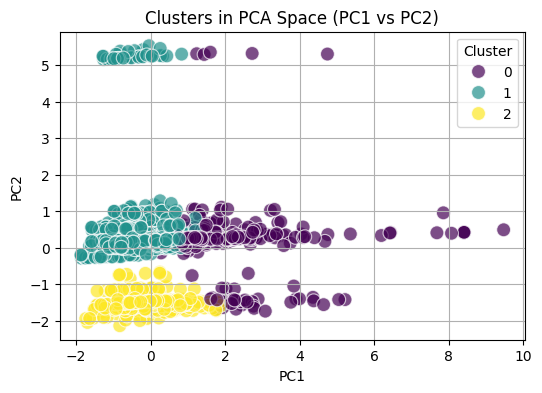

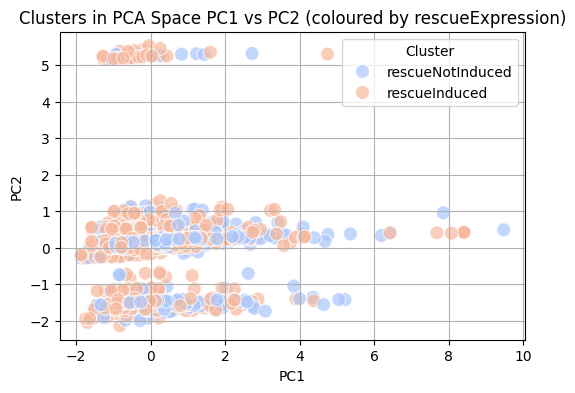

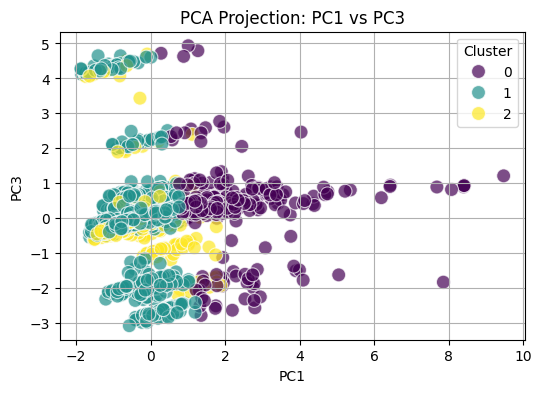

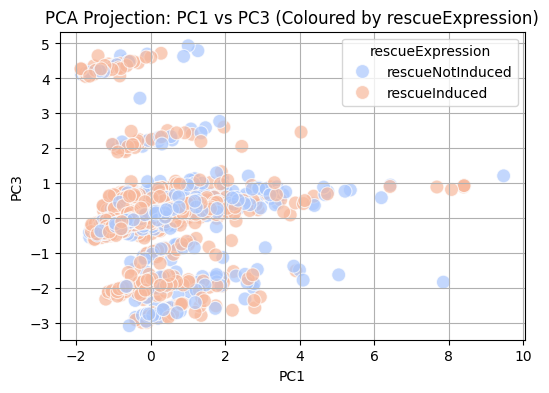

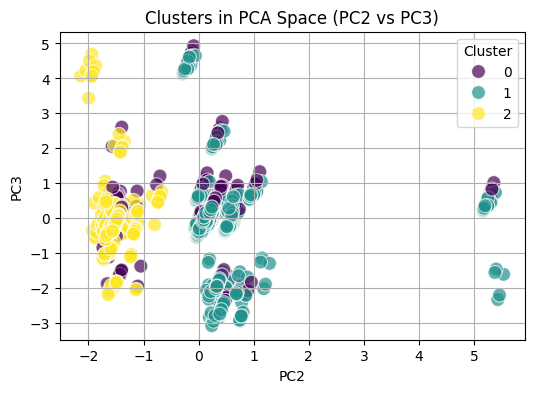

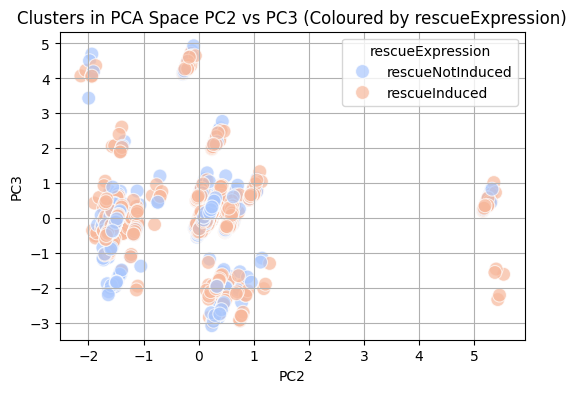

In [7]:
'''Post-PCA: Clustering Patterns'''

from sklearn.cluster import KMeans
import seaborn as sns

# Run K-means clustering on the principal components
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = clusters

# Plot clusters (PC1 vs PC2)
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters in PCA Space (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# PC1 vs PC2 with rescue expression 
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='rescueExpression', palette='coolwarm', s=100, alpha=0.7)
plt.title('Clusters in PCA Space PC1 vs PC2 (coloured by rescueExpression)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# PC1 vs PC3 
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC3', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('PCA Projection: PC1 vs PC3')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid(True)
plt.show()


# PC1 vs PC3 with rescueExpression 
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC3', hue='rescueExpression', palette='coolwarm', s=100, alpha=0.7)
plt.title('PCA Projection: PC1 vs PC3 (Coloured by rescueExpression)')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid(True)
plt.show()

# PC2 vs PC3
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC2', y='PC3', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters in PCA Space (PC2 vs PC3)')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True)
plt.show()

# PC2 vs PC3 with rescueExpression
plt.figure(figsize=(6, 4))
sns.scatterplot(data=pca_df, x='PC2', y='PC3', hue='rescueExpression', palette='coolwarm', s=100, alpha=0.7)
plt.title('Clusters in PCA Space PC2 vs PC3 (Coloured by rescueExpression)')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True)
plt.show()

### Comments

#### PC1 vs PC2 

All three clusters are clearly separated and distinct. The clusters are mainly aligned along the PC1 axis, which implies that PC1 captures a large portion of variation, while PC2 might capture some more sublte variations. 

The rescueExpression coloured points are well distributed through all the clusters. However a large portion of rescueInduced seem to occur in lower values of PC1, this partial separation suggests PC1 may have a more important role in rescueExpression. 

#### PC1 vs PC3

Using PC3 instead of PC2 as the y axis introduces more complexity. The clusters are significantly less cleanly separated along the PC3 axis. This indicates that PC3 explains less meaningful variation than PC1 and PC2. 

The rescueExpression coloured points also had poorly defined separation, indicating that PC3 might not correlate strongly with rescueExpression outcomes. 

#### PC2 vs PC3

The clustering is not very clear, though PC2 shows stronger cluster separation. 

The rescueExpression colour points still show random distribution with no strong patterns.


### Overall takeaways:

PC1 and PC2 have stronger importance than PC3. 
PC1 captures the most variance, which has a strong positive contribution from psi, suggesting psi is the most important factor. 
